In [4]:
%pip install gymnasium
%pip install stable_baselines3
%pip install stable_baselines


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install keras
%pip install optuna


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
import gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from gym_anytrading.envs import StocksEnv
import gym_anytrading
import quantstats as qs
import pandas as pd
import matplotlib.pyplot as plt
import logging
import optuna



In [4]:
logger = logging.getLogger('training')
logger.setLevel(logging.INFO)

file_handler = logging.FileHandler('training.log')
formatter = logging.Formatter('%(asctime)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

In [5]:
import yfinance as yf
vgt_data = yf.download("VGT", period = '5y')
voo_data = yf.download("VOO", period = '5y')
spy_data = yf.download('SPY', period = '5y')
data = pd.concat([vgt_data, voo_data]) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
#Rolling window split. Two year training data

train_df = data[:2*365]
val_df_1 = data[2*365:3*365]
val_df_2 = data[3*365:4*365]
val_df_3 = data[4*365:5*365]

In [25]:
def ModelCreation():

    #Creating Logging env
    logger = logging.getLogger('training')
    logger.setLevel(logging.INFO)

    file_handler = logging.FileHandler('training.log')
    formatter = logging.Formatter('%(asctime)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    #Creating training env

    window_size = 10
    start_index = window_size
    end_index = len(data)

    train_env = gym.make(
            'stocks-v0',
            df = train_df,
            window_size = window_size,
            frame_bound = (start_index, end_index)
        )

    val_env1 = gym.make(
        'stocks-v0',
        df = val_df_1,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )




    val_env2 = gym.make(
        'stocks-v0',
        df = val_df_2,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )



    val_env3 = gym.make(
        'stocks-v0',
        df = val_df_3,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

    env1 = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])

    #Setting up hyperparameter tuners

    def optimizePPO(trial):
        return {
            'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
            'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1.),
            'ent_coef' : trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
            'clip_range': trial.suggest_uniform('clip_range', 0.1, 0.4),
            'n_epochs' : int(trial.suggest_loguniform('n_epochs', 1, 48)),
            'gae_lambda': trial.suggest_uniform('gae_lambda', 0.8, 1.)
        }

    def OptimizeA2C(trial):

        return {
            'n_steps': trial.suggest_int('n_steps', 16, 2048),
            'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
            'ent_coef': trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
            'vf_coef': trial.suggest_loguniform('vf_coef', 0.5, 1.) 
        }

    file_handler.close()
    logger.removeHandler(file_handler)

    file_handler = logging.FileHandler('training.log')
    logger.addHandler(file_handler)


    logger.info('Starting Hyperparameter Tuning...')

    
    def Optimize_PPO_agent(trial):
        model_params = optimizePPO(trial)
        env = env1
        model = PPO('MlpPolicy', train_env, verbose=1, **model_params)
        model.learn(10000)

        rewards = []
        global n_steps
        n_steps = 0

        n_episodes, reward_sum = 0, 0.0

        obs = env.reset()
        while n_episodes < 4:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            reward_sum += reward

            if done.all():
                rewards.append(reward_sum)
                reward_sum = 0.0
                n_episodes += 1
                obs = env.reset()

        last_reward = np.mean(rewards)
        trial.report(-1 * last_reward, step = n_steps)

        return -1 * last_reward

    def Optimize_A2C_agent(trial):
        model_params = OptimizeA2C(trial)
        env = env1
        model = A2C('MlpPolicy', train_env, verbose=1, **model_params)
        model.learn(10000)

        rewards = []
        global n_steps
        n_steps = 0

        n_episodes, reward_sum = 0, 0.0

        obs = env.reset()
        while n_episodes < 4:
            action, _ = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            reward_sum += reward

            if done.all():
                rewards.append(reward_sum)
                reward_sum = 0.0
                n_episodes += 1
                obs = env.reset()

        last_reward = np.mean(rewards)
        trial.report(-1 * last_reward, step = n_steps)

        return -1 * last_reward


    ppo_study = optuna.create_study()
    ppo_study.optimize(Optimize_PPO_agent, n_trials = 3)

    a2c_study = optuna.create_study()
    a2c_study.optimize(Optimize_A2C_agent, n_trials = 3)

    ppo_best_params = ppo_study.best_params
    ppo_best_params['clip_range'] = float(ppo_best_params['clip_range'])
    ppo_best_params['n_steps'] = int(ppo_best_params['n_steps'])
    ppo_best_params['n_epochs'] = int(ppo_best_params['n_epochs'])
    
    a2c_best_params = a2c_study.best_params

    logger.info(f'Hyperparameter tuning is complete. The A2C best parameters are: {a2c_best_params} and the best PPO parameters are: {ppo_best_params}')

    logger.info('Initializing the PPO and A2C models...')
    ppo_agent = PPO('MlpPolicy', train_env, verbose=1, **ppo_best_params)
    a2c_agent = A2C('MlpPolicy', train_env, verbose=1, **a2c_best_params)

    logger.info('Training the PPO Agent...')
    ppo_agent.learn(total_timesteps=10000)

    logger.info('Training the A2C Agent...')
    a2c_agent.learn(total_timesteps=10000)

    logger.info('Training is complete')

    envs = [val_env1, val_env2, val_env3]

    def evalModel():

        num_years = 3
        counter = 3

        while counter <= num_years:

            for i in envs:
                ppo_rewards = []
                obs1 = i.reset()

                while True:
                    action, _ = ppo_agent.predict(obs1)
                    logger.info(f'PPO Took action {action} in state {obs1}')
                    obs, reward, done, info = i.step(action)
                    ppo_rewards.append(reward)

                    if done:
                        break

                print(f'PPO average validation for year {counter} reward: ', np.mean(ppo_rewards))


                a2c_rewards = []
                obs2 = val_env1.reset()

                while True:
                    action, _ = a2c_agent.predict(obs2)
                    obs, reward, done, info = val_env1.step(action)
                    a2c_rewards.append(reward)

                    if done:
                        break

                print(f'A2C average validation for year {counter} reward: ', np.mean(a2c_rewards))

                if np.mean(ppo_rewards) > np.mean(a2c_rewards):
                    agent = ppo_agent
                    action, _ = agent.predict(obs1)
                    print(f'Agent chosen for year {counter} is PPO')
                else:
                    agent = a2c_agent
                    action, _ = agent.predict(obs2)
                    print(f'Agent chosen for year {counter} is A2C')

                counter += 1

                ppo_val = ppo_rewards
                a2c_val = a2c_rewards

                plt.bar(np.arange(len(ppo_val)), ppo_val, label = 'PPO')
                plt.bar(np.arange(len(a2c_val)), a2c_val, label = 'A2C')
                plt.xlabel(f'Validation Performance for year {counter}')
                plt.ylabel('Average Reward')
                plt.legend()
                plt.show()

        



        print("info:", info)
        plt.plot(ppo_rewards, label = 'PPO')
        plt.plot(a2c_rewards, label = 'A2C')

        plt.legend()
        plt.title('Agent Rewards')
        plt.show()



    evalModel()

    




C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
[I 2023-08-01 20:09:13,928] A new study created in memory with name: no-name-6810db16-abd8-4453-b3c7-

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2015 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 203  |
-----------------------------


C:\Users\12016\AppData\Local\Temp\ipykernel_19396\1395878264.py:57: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
C:\Users\12016\AppData\Local\Temp\ipykernel_19396\1395878264.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_19396\1395878264.py:59: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate' : trial.suggest_loguniform('learning_

------------------------------------------
| time/                   |              |
|    fps                  | 666          |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 406          |
| train/                  |              |
|    approx_kl            | 6.328536e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.202        |
|    entropy_loss         | -0.693       |
|    explained_variance   | -0.0135      |
|    learning_rate        | 2.68e-05     |
|    loss                 | 11.1         |
|    n_updates            | 34           |
|    policy_gradient_loss | -0.00037     |
|    value_loss           | 10.8         |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 582          |
|    iterations           | 3            |
|    time_elapsed         | 1            |
|    total_

[I 2023-08-01 20:16:11,306] Trial 0 finished with value: -8072.07763671875 and parameters: {'n_steps': 203.31743953338682, 'gamma': 0.9740142364354527, 'learning_rate': 2.67959928579175e-05, 'ent_coef': 7.103180360539855e-06, 'clip_range': 0.2019924031012691, 'n_epochs': 34.17904808417977, 'gae_lambda': 0.8075292862649016}. Best is trial 0 with value: -8072.07763671875.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2005 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 30   |
-----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 412       |
|    iterations           | 2         |
|    time_elapsed         | 0         |
|    total_timesteps      | 60        |
| train/                  |           |
|    approx_kl            | 40.634384 |
|    clip_fraction        | 0.971     |
|    clip_range           | 0.112     |
|    entropy_loss         | -0.0198   |
|    explained_variance   | -0.0242   |
|    learning_rate        | 0.414     |
|    loss                 | 32.7      |
|    n_updates            | 35        |
|    policy_gradient_loss | 0.32      |
|    value_loss           | 57        |
----------------

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 30`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 30
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=30 and n_envs=1)
  warnings.warn(


---------------------------------------
| time/                   |           |
|    fps                  | 322       |
|    iterations           | 3         |
|    time_elapsed         | 0         |
|    total_timesteps      | 90        |
| train/                  |           |
|    approx_kl            | 0.0       |
|    clip_fraction        | 0         |
|    clip_range           | 0.112     |
|    entropy_loss         | -1.48e-40 |
|    explained_variance   | 0         |
|    learning_rate        | 0.414     |
|    loss                 | 37.8      |
|    n_updates            | 70        |
|    policy_gradient_loss | -1.08e-08 |
|    value_loss           | 26.9      |
---------------------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 297       |
|    iterations           | 4         |
|    time_elapsed         | 0         |
|    total_timesteps      | 120       |
| train/                  |           |


[I 2023-08-01 20:23:30,652] Trial 1 finished with value: -0.0 and parameters: {'n_steps': 30.157259300344226, 'gamma': 0.9775765208692195, 'learning_rate': 0.414400746129822, 'ent_coef': 8.545847620287479e-05, 'clip_range': 0.11178793875329958, 'n_epochs': 35.852015650282986, 'gae_lambda': 0.8433006908449285}. Best is trial 0 with value: -8072.07763671875.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2114 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 116  |
-----------------------------


C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 116`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 52
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=116 and n_envs=1)
  warnings.warn(


-----------------------------------------
| time/                   |             |
|    fps                  | 785         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 232         |
| train/                  |             |
|    approx_kl            | 0.003491283 |
|    clip_fraction        | 0.063       |
|    clip_range           | 0.284       |
|    entropy_loss         | -0.68       |
|    explained_variance   | -0.0063     |
|    learning_rate        | 0.00396     |
|    loss                 | 22.5        |
|    n_updates            | 32          |
|    policy_gradient_loss | 0.000945    |
|    value_loss           | 47.3        |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 652        |
|    iterations           | 3          |
|    time_elapsed         | 0          |
|    total_timesteps      | 348        

[I 2023-08-01 20:30:51,313] Trial 2 finished with value: 293.427001953125 and parameters: {'n_steps': 116.18270213534593, 'gamma': 0.9898866068546974, 'learning_rate': 0.00396160583039318, 'ent_coef': 3.577176187201854e-07, 'clip_range': 0.28445979645968034, 'n_epochs': 32.375792027372235, 'gae_lambda': 0.9674330438896108}. Best is trial 0 with value: -8072.07763671875.
[I 2023-08-01 20:30:51,314] A new study created in memory with name: no-name-89bf386d-0ec8-4239-a2a7-0189f0feefb6
C:\Users\12016\AppData\Local\Temp\ipykernel_19396\1395878264.py:70: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_19396\1395878264.py:71: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-01 20:37:48,601] Trial 0 finished with value: 209.37835693359375 and parameters: {'n_steps': 1972, 'gamma': 0.9945144618187656, 'learning_rate': 0.0006302850040147695, 'ent_coef': 5.60137776151676e-06, 'vf_coef': 0.9713170489886809}. Best is trial 0 with value: 209.37835693359375.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-01 20:44:37,173] Trial 1 finished with value: -1256.910400390625 and parameters: {'n_steps': 903, 'gamma': 0.9495800086342133, 'learning_rate': 0.0006152837971449883, 'ent_coef': 0.002647663884233181, 'vf_coef': 0.82371978512727}. Best is trial 1 with value: -1256.910400390625.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


[I 2023-08-01 20:50:57,193] Trial 2 finished with value: -0.0 and parameters: {'n_steps': 1835, 'gamma': 0.9581797484580765, 'learning_rate': 0.4146884526204802, 'ent_coef': 1.7093971032732474e-06, 'vf_coef': 0.782485037744431}. Best is trial 1 with value: -1256.910400390625.


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2212 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 203  |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 753         |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 406         |
| train/                  |             |
|    approx_kl            | 0.004401641 |
|    clip_fraction        | 0           |
|    clip_range           | 0.202       |
|    entropy_loss         | -0.691      |
|    explained_variance   | 0.000329    |
|    learning_rate        | 2.68e-05    |
|    loss                 | 13.3        |
|    n_updates

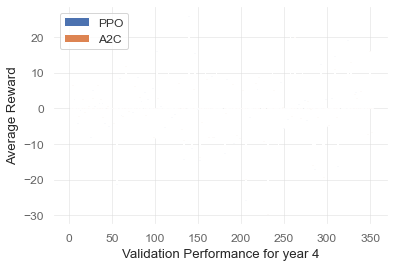

PPO average validation for year 4 reward:  0.3194350765249823
A2C average validation for year 4 reward:  -0.4077401888572564
Agent chosen for year 4 is PPO


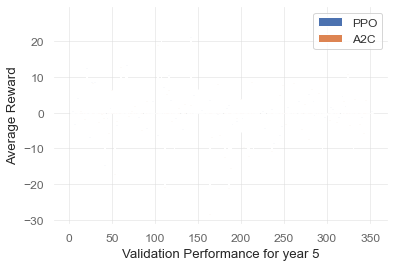

PPO average validation for year 5 reward:  -0.05793848414879061
A2C average validation for year 5 reward:  -0.11855872202727755
Agent chosen for year 5 is PPO


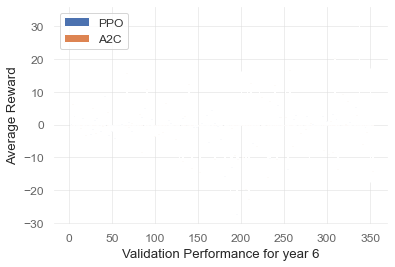

info: {'total_reward': -41.96978759765625, 'total_profit': 0.273520389025079, 'position': 0}


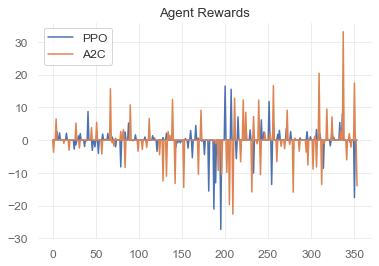

AttributeError: 'Study' object has no attribute 'importance'

In [26]:
ModelCreation()

In [18]:
window_size = 10
start_index = window_size
end_index = len(data)

train_env = gym.make(
        'stocks-v0',
        df = train_df,
        window_size = window_size,
        frame_bound = (start_index, end_index)
    )

val_env1 = gym.make(
    'stocks-v0',
    df = val_df_1,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)




val_env2 = gym.make(
    'stocks-v0',
    df = val_df_2,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)



val_env3 = gym.make(
    'stocks-v0',
    df = val_df_3,
    window_size = window_size,
    frame_bound = (start_index, end_index)
)

env1 = DummyVecEnv([lambda : train_env, lambda : val_env1, lambda : val_env2, lambda : val_env3])


n_cpu = 4

def optimizePPO(trial):
    return {
        'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
        'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-5, 1.),
        'ent_coef' : trial.suggest_loguniform('ent_coef', 1e-8, 1e-1),
        'clip_range': trial.suggest_uniform('cliprange', 0.1, 0.4),
        'n_epochs' : int(trial.suggest_loguniform('noptepochs', 1, 48)),
        'gae_lambda': trial.suggest_uniform('lam', 0.8, 1.)
    }

def OptimizeA2C(trial):

  return {
    'n_steps': trial.suggest_int('n_steps', 16, 2048),
    'gamma': trial.suggest_uniform('gamma', 0.9, 0.9999),
    'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1.),
    'entropy_coef': trial.suggest_loguniform('entropy_coef', 1e-8, 1e-1),
    'value_loss_coef': trial.suggest_loguniform('value_loss_coef', 0.5, 1.) 
  }

n_steps = 0

def Optimize_PPO_agent(trial):
    model_params = optimizePPO(trial)
    env = env1
    model = PPO('MlpPolicy', train_env, verbose=1, **model_params)
    model.learn(10000)

    rewards = []
    global n_steps

    n_episodes, reward_sum = 0, 0.0

    obs = env.reset()
    while n_episodes < 4:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        reward_sum += reward

        if done.all():
            rewards.append(reward_sum)
            reward_sum = 0.0
            n_episodes += 1
            obs = env.reset()

    last_reward = np.mean(rewards)
    trial.report(-1 * last_reward, step = n_steps)

    return -1 * last_reward


def Optimize_A2C_agent(trial):
    model_params = OptimizeA2C(trial)
    env = env1
    model = A2C('MlpPolicy', train_env, verbose=1, **model_params)
    model.learn(10000)

    rewards = []
    global n_steps

    n_episodes, reward_sum = 0, 0.0

    obs = env.reset()
    while n_episodes < 4:
        action, _ = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        reward_sum += reward

        if done.all():
            rewards.append(reward_sum)
            reward_sum = 0.0
            n_episodes += 1
            obs = env.reset()

    last_reward = np.mean(rewards)
    trial.report(-1 * last_reward, step = n_steps)

    return -1 * last_reward

    

C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (10, 2)
  logger.warn(
C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [23]:
study = optuna.create_study()
study.optimize(Optimize_PPO_agent, n_trials = 1)



[I 2023-08-01 14:48:29,533] A new study created in memory with name: no-name-398a9f8a-a69a-45a5-bd86-7668e4da350c
C:\Users\12016\AppData\Local\Temp\ipykernel_13956\918136109.py:45: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'n_steps' : int(trial.suggest_loguniform('n_steps', 16, 2048)),
C:\Users\12016\AppData\Local\Temp\ipykernel_13956\918136109.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma' : trial.suggest_loguniform('gamma', 0.9, 0.9999),
C:\Users\12016\AppData\Local\Temp\ipykernel_13956\918136109.py:47: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/release

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 1699 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 451  |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 719         |
|    ep_rew_mean          | 114         |
| time/                   |             |
|    fps                  | 1329        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 902         |
| train/                  |             |
|    approx_kl            | 0.026152235 |
|    clip_fraction        | 0.0519      |
|    clip_range           | 0.244       |
|    entropy_loss         | -0.679      |
|    explained_variance   | 0.0032      |
|    learning_rate        | 0.000444    |
|    loss               

[W 2023-08-01 14:55:10,560] Trial 0 failed with parameters: {'n_steps': 451.12033220489013, 'gamma': 0.9617187267622725, 'learning_rate': 0.000443853526740911, 'ent_coef': 0.028552271773859387, 'cliprange': 0.2439260175845944, 'noptepochs': 7.791510724032618, 'lam': 0.9594901554244898} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\12016\AppData\Local\Temp\ipykernel_13956\918136109.py", line 79, in Optimize_PPO_agent
    action, _ = model.predict(obs)
  File "C:\Users\12016\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\base_class.py", line 555, in predict
    return self.policy.predict(observation, 

KeyboardInterrupt: 

In [40]:
study.best_params

{'n_steps': 47.69492578331755,
 'gamma': 0.9210157662984991,
 'learning_rate': 9.977870235715527e-05,
 'ent_coef': 7.971129466598355e-06,
 'cliprange': 0.3076116027483111,
 'noptepochs': 5.248265181259201,
 'lam': 0.9777987276354275}

In [56]:
env.history

{}

In [54]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

KeyError: 'total_profit'